<h1><center>The World of Haiku</center></h1>
<center>by Chao Xu</center>

<h2>I: Introduction

Haiku is a type of short form poetry that originated in Japan. For this project, I want to use NLP techniques I learned from this class to do the text summarization, data analysis, and finally haiku generation.

To see my project on GutHub: https://github.com/Lilacbibi/CISB63_final

Data used for this project:
- <b>Haiku introduction</b>: https://en.wikipedia.org/wiki/Haiku
- <b>Haiku datase</b>t: https://www.kaggle.com/datasets/hjhalani30/haiku-dataset

The main steps are as follows:

- Use text summarization (<b>TF-IDF</b>) to generate a brief introduction to haiku and visualize Named Entities with <b>spaCy</b>.
- Use <b>TextBolb</b> to translate original Japanese haiku.
- Visualize haiku Dependency Parse using <b>spaCy</b>
- Create <b>Word2Vec</b> embeddings and visualize word vectors using <b>UMAP</b>
- Clustering haiku using <b>NMF</b>
- Visualize top words of each topic using <b>matplotlib</b> and clustered topics using <b>WordCloud</b>
- Generate haiku using <b>LSTM</b>
- To clean the text, multipule NLP and EDA techniques are used such as <b>ReGex</b>, <b>Tokenization</b>, <b>stop words</b>, <b>handling missing values</b>, etc.

<h2>II: What is Haiku?
    <i>  —A introduction using text summarization</i>

<h3>Import libraries

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<h3>Text Preparation

The text below is copied directly from Wikipedia: https://en.wikipedia.org/wiki/Haiku

In [2]:
intro = """
Haiku (俳句, listenⓘ) is a type of short form poetry that originated in Japan. Traditional Japanese haiku consist of three phrases composed of 17 phonetic units (called on in Japanese, which are similar to syllables) in a 5, 7, 5 pattern;[1] that include a kireji, or "cutting word";[2] and a kigo, or seasonal reference. Similar poems that do not adhere to these rules are generally classified as senryū.[3]

Haiku originated as an opening part of a larger Japanese poem called renga. These haiku written as an opening stanza were known as hokku and over time they began to be written as stand-alone poems. Haiku was given its current name by the Japanese writer Masaoka Shiki at the end of the 19th century.[4]

Originally from Japan, haiku today are written by authors worldwide. Haiku in English and haiku in other languages have different styles and traditions while still incorporating aspects of the traditional haiku form. Non-Japanese haiku vary widely on how closely they follow traditional elements. Additionally, a minority movement within modern Japanese haiku (現代俳句, gendai-haiku), supported by Ogiwara Seisensui and his disciples, has varied from the tradition of 17 on as well as taking nature as their subject.

In Japanese, haiku are traditionally printed as a single line, while haiku in English often appear as three lines, although variations exist. There are several other forms of Japanese poetry related to haiku, such as tanka, as well as other art forms that incorporate haiku, such as haibun and haiga.
"""

<h4>Split the text into sentences

In [3]:
# Split the text into sentences keeping the original format
original_sentences = intro.strip().split('.')

#Print the whole text
print(original_sentences)

['Haiku (俳句, listenⓘ) is a type of short form poetry that originated in Japan', ' Traditional Japanese haiku consist of three phrases composed of 17 phonetic units (called on in Japanese, which are similar to syllables) in a 5, 7, 5 pattern;[1] that include a kireji, or "cutting word";[2] and a kigo, or seasonal reference', ' Similar poems that do not adhere to these rules are generally classified as senryū', '[3]\n\nHaiku originated as an opening part of a larger Japanese poem called renga', ' These haiku written as an opening stanza were known as hokku and over time they began to be written as stand-alone poems', ' Haiku was given its current name by the Japanese writer Masaoka Shiki at the end of the 19th century', '[4]\n\nOriginally from Japan, haiku today are written by authors worldwide', ' Haiku in English and haiku in other languages have different styles and traditions while still incorporating aspects of the traditional haiku form', ' Non-Japanese haiku vary widely on how clo

Some characters can be removed to make the text clean:
- In-text citation numbers
- Extra space at the beginning of some sentences
- The ', listenⓘ' is an audio link that we do not need
- There are some Japanese words cannot be removed as well as parentheses

<h4>Clean the text with RegEx

I Create a function to clean the original text with <b>RegEx</b>.

In [4]:
def clean_text(text):
    #Create a list of replecements
    replacements = [
        (r', listenⓘ', ''),
        (r'(\[\d+\])', ''),
        (r'^ ', '')
    ]
    for old, new in replacements:
        text = re.sub(old, new, text)
    return text

In [5]:
#Apply the function to create clean sentences
clean_sentences = []
for sentence in original_sentences:
    clean_sentence = clean_text(sentence)
    clean_sentences.append(clean_sentence)

Print the sentences to see the result:

In [6]:
for sentence in clean_sentences:
    print(sentence)

Haiku (俳句) is a type of short form poetry that originated in Japan
Traditional Japanese haiku consist of three phrases composed of 17 phonetic units (called on in Japanese, which are similar to syllables) in a 5, 7, 5 pattern; that include a kireji, or "cutting word"; and a kigo, or seasonal reference
Similar poems that do not adhere to these rules are generally classified as senryū


Haiku originated as an opening part of a larger Japanese poem called renga
These haiku written as an opening stanza were known as hokku and over time they began to be written as stand-alone poems
Haiku was given its current name by the Japanese writer Masaoka Shiki at the end of the 19th century


Originally from Japan, haiku today are written by authors worldwide
Haiku in English and haiku in other languages have different styles and traditions while still incorporating aspects of the traditional haiku form
Non-Japanese haiku vary widely on how closely they follow traditional elements
Additionally, a min

Now the text looks nice and clean. It's time to preprocess the text for the TF-IDF matrix:

<h4>Remove punctuation and stopwords

In [7]:
# Preprocess the text (remove punctuation and stopwords)
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lilac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lilac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create a function to remove puctuations, parentheses, stop words and lower the cases.

In [8]:
def preprocess_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum()]
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [9]:
#sentences = sent_tokenize(intro)
preprocessed_sentences = []
for sentence in clean_sentences:
    preprocessed_sentence = preprocess_text(sentence)
    preprocessed_sentences.append(preprocessed_sentence)

In [10]:
print(preprocessed_sentences)

['haiku 俳句 type short form poetry originated japan', 'traditional japanese haiku consist three phrases composed 17 phonetic units called japanese similar syllables 5 7 5 pattern include kireji cutting word kigo seasonal reference', 'similar poems adhere rules generally classified senryū', 'haiku originated opening part larger japanese poem called renga', 'haiku written opening stanza known hokku time began written poems', 'haiku given current name japanese writer masaoka shiki end 19th century', 'originally japan haiku today written authors worldwide', 'haiku english haiku languages different styles traditions still incorporating aspects traditional haiku form', 'haiku vary widely closely follow traditional elements', 'additionally minority movement within modern japanese haiku 現代俳句 supported ogiwara seisensui disciples varied tradition 17 well taking nature subject', 'japanese haiku traditionally printed single line haiku english often appear three lines although variations exist', 's

There is an empty string as the last list element. I want to remove it before create the matrix.

In [11]:
preprocessed_sentences = preprocessed_sentences[:-1]
print(preprocessed_sentences)

['haiku 俳句 type short form poetry originated japan', 'traditional japanese haiku consist three phrases composed 17 phonetic units called japanese similar syllables 5 7 5 pattern include kireji cutting word kigo seasonal reference', 'similar poems adhere rules generally classified senryū', 'haiku originated opening part larger japanese poem called renga', 'haiku written opening stanza known hokku time began written poems', 'haiku given current name japanese writer masaoka shiki end 19th century', 'originally japan haiku today written authors worldwide', 'haiku english haiku languages different styles traditions still incorporating aspects traditional haiku form', 'haiku vary widely closely follow traditional elements', 'additionally minority movement within modern japanese haiku 現代俳句 supported ogiwara seisensui disciples varied tradition 17 well taking nature subject', 'japanese haiku traditionally printed single line haiku english often appear three lines although variations exist', 's

<h3>Calculate the TF-IDF scores and generate summary

In [12]:
# Calculate TF-IDF scores
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(preprocessed_sentences)
tfidf_scores = tfidf_matrix.sum(axis=1)

top_sentence_indices = np.argsort(tfidf_scores, axis=0)[-4:]

In [13]:
def generate_summary(preprocessed_sentences, clean_sentences, n=3):
    
    #Create a matrix with TF-IDF scores and calculate the total scores of each sentences 
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(preprocessed_sentences)
    tfidf_scores = tfidf_matrix.sum(axis=1)

    #Find the most important n sentences and sort the indicies to the original order
    top_sentence_indices = np.argsort(tfidf_scores, axis=0)[-n:]
    new_top_sentence_indices = np.sort(top_sentence_indices, axis=0)
    top_sentences = []
    

    #Generate the summary based on the clean text and top sentence indicies
    summary = ''
    for i in range(len(new_top_sentence_indices)):
        index = new_top_sentence_indices.tolist()[i][0]
        val = clean_sentences[index]
        #Indent the first line if it is the beginning a new paragraph (\n\n)
        val = re.sub(r'\n\n', '\n\t', val)      
        #Indent the first line if it is the beginning of the summary
        if i==0:
            val = '\t' + val

        summary += ''.join(val) +  '. '

    return summary

In [14]:
summary = generate_summary(preprocessed_sentences, clean_sentences, 4)
print(summary)

	Traditional Japanese haiku consist of three phrases composed of 17 phonetic units (called on in Japanese, which are similar to syllables) in a 5, 7, 5 pattern; that include a kireji, or "cutting word"; and a kigo, or seasonal reference. Haiku in English and haiku in other languages have different styles and traditions while still incorporating aspects of the traditional haiku form. Additionally, a minority movement within modern Japanese haiku (現代俳句, gendai-haiku), supported by Ogiwara Seisensui and his disciples, has varied from the tradition of 17 on as well as taking nature as their subject. 
	In Japanese, haiku are traditionally printed as a single line, while haiku in English often appear as three lines, although variations exist. 


<h3>Visualize Named Entities Using spaCy

In [15]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

colors = {'ORG': 'linear-gradient(to bottom right, #9E7BFF, #BDEDFF)', 
          'DATE': 'radial-gradient(#FFFFCC, #50C878)'}
options = {'ents': ['ORG', 'DATE'], 'colors':colors}

text = nlp(summary)
displacy.render(text, style='ent', jupyter=True, options=options)

<h2>III: The beauty of original Japanese Haiku
    <i>  —Translating Japanese Haiku using TextBlob</i>

I select some haiku written by 松尾芭蕉(Matsuo Bashō), the most famous poet in Japan, to share the beauty of Japanese haiku.

Because these haiku are printed as a single line, so I divided them into three lines to adapt English format.

<h3>Import libraries

In [16]:
from textblob import TextBlob

In [17]:
def haiku_translation(text):
    haiku = TextBlob(text)
    print('Original Japanese Haiku:')
    #print('─' * 25)
    print(text)
    print('\nEnglish translation:')
    #print('─' * 25)
    print(haiku.translate(from_lang='ja', to='en'))

In [18]:
haiku_list = ['夕晴れや\n桜に涼む\n波の華', '古池や\n蛙飛びこむ\n水の音', '閑けさや\n岩にしみいる\n蝉の声']

In [19]:
for haiku in haiku_list:
    haiku_translation(haiku)
    print('┅ ' * 15, '\n')

Original Japanese Haiku:
夕晴れや
桜に涼む
波の華

English translation:
Sunny evening
Cool down on cherry blossoms
Wavy flower
┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅  

Original Japanese Haiku:
古池や
蛙飛びこむ
水の音

English translation:
old pond
Jump in the frog
Sound of water
┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅  

Original Japanese Haiku:
閑けさや
岩にしみいる
蝉の声

English translation:
Calmness
Push in the rock
Cicada's voice
┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅ ┅  



<h2>IV: Haiku Dataset Analysis

The dataset I use can be found in Kaggle: https://www.kaggle.com/datasets/hjhalani30/haiku-dataset

<h3>Load the dataset and Handle Missing Values

In [20]:
data = pd.read_csv('data/all_haiku.csv')
data.head()

,Unnamed: 0,0,1,2,source,hash
0,0,fishing boats,colors of,the rainbow,tempslibres,FISHINGBOATSCOLORSOFTHERAINBOW
1,1,ash wednesday--,trying to remember,my dream,tempslibres,ASHWEDNESDAYTRYINGTOREMEMBERMYDREAM
2,2,snowy morn--,pouring another cup,of black coffee,tempslibres,SNOWYMORNPOURINGANOTHERCUPOFBLACKCOFFEE
3,3,shortest day,flames dance,in the oven,tempslibres,SHORTESTDAYFLAMESDANCEINTHEOVEN
4,4,haze,half the horse hidden,behind the house,tempslibres,HAZEHALFTHEHORSEHIDDENBEHINDTHEHOUSE


In [21]:
data.tail()

,Unnamed: 0,0,1,2,source,hash
144118,118007,I'm not asking did,you say it nor clarify,what you said neither,twaiku,IMNOTASKINGDIDYOUSAYITNORCLARIFYWHATYOUSAIDNEI...
144119,118008,You are truly a,moron or a liar I'm,inclined to think both,twaiku,YOUARETRULYAMORONORALIARIMINCLINEDTOTHINKBOTH
144120,118009,Ain't no selfie on,this earth that's gonna make me,like Theresa May,twaiku,AINTNOSELFIEONTHISEARTHTHATSGONNAMAKEMELIKETHE...
144121,118010,is doing a great,job turning Independents,into Democrats,twaiku,ISDOINGAGREATJOBTURNINGINDEPENDENTSINTODEMOCRATS
144122,118011,Wanted to send a,quick follow up on if the,blood is loud Talk soon,twaiku,WANTEDTOSENDAQUICKFOLLOWUPONIFTHEBLOODISLOUDTA...


Column '0', '1', '2' represent three lines of Haiku. Although haiku in this dataset have three lines, not all of them have the correct 5-7-5 syllable pattern. Based on the dataset, I assume the haiku generated later will not follow the 5-7-5 rules. Instead, it will generate haiku-like poem with typical 3 lines.

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144123 entries, 0 to 144122
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  144123 non-null  int64 
 1   0           144123 non-null  object
 2   1           144123 non-null  object
 3   2           144122 non-null  object
 4   source      144123 non-null  object
 5   hash        144122 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.6+ MB


<h4>Check the missing value

In [23]:
data.isnull().sum()

Unnamed: 0    0
0             0
1             0
2             1
source        0
hash          1
dtype: int64

There is only one missing value in the third line of one haiku.

In [24]:
#Check the haiku with null value
data[data['2'].isnull()]

,Unnamed: 0,0,1,2,source,hash
18799,28,the busker,buttons his collar,NaN,sballas,NaN


In [25]:
#Drop the row
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144122 entries, 0 to 144122
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  144122 non-null  int64 
 1   0           144122 non-null  object
 2   1           144122 non-null  object
 3   2           144122 non-null  object
 4   source      144122 non-null  object
 5   hash        144122 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.7+ MB


In [26]:
data.isnull().sum()

Unnamed: 0    0
0             0
1             0
2             0
source        0
hash          0
dtype: int64

Now there is no missing values in the dataset.

<h3>Preprocess Data

I only need to use three lines of haiku and the source. I will keep these lines and combine each line into a full haiku as a new column.

In [27]:
df_haiku = data[['source','0','1','2']]
df_haiku.head()

,source,0,1,2
0,tempslibres,fishing boats,colors of,the rainbow
1,tempslibres,ash wednesday--,trying to remember,my dream
2,tempslibres,snowy morn--,pouring another cup,of black coffee
3,tempslibres,shortest day,flames dance,in the oven
4,tempslibres,haze,half the horse hidden,behind the house


<h4>Add a new column with all three lines of each haiku

In [28]:
df_haiku = df_haiku.assign(full=lambda x: (x['0']+' '+ x['1'] + ' ' + x['2']))
df_haiku.head()

,source,0,1,2,full
0,tempslibres,fishing boats,colors of,the rainbow,fishing boats colors of the rainbow
1,tempslibres,ash wednesday--,trying to remember,my dream,ash wednesday-- trying to remember my dream
2,tempslibres,snowy morn--,pouring another cup,of black coffee,snowy morn-- pouring another cup of black coffee
3,tempslibres,shortest day,flames dance,in the oven,shortest day flames dance in the oven
4,tempslibres,haze,half the horse hidden,behind the house,haze half the horse hidden behind the house


Since there are not too many words in one haiku and it is necessary to have stop words in poems, I will not remove stop words in the dataset. However, I still need to remove alphanumeric characters and convert the text into lowercases just in case there are capital letters in the dataset.

<h4>Add a new column with cleaned text

In [29]:
#Function to clean the full haiku sentence
def clean_haiku(text):
    words = [word.lower() for word in word_tokenize(text) if word.isalnum()] 
    return ' '.join(words)

In [30]:
df_haiku['clean_text'] = df_haiku['full'].apply(lambda x: clean_haiku(x))
df_haiku.head()

,source,0,1,2,full,clean_text
0,tempslibres,fishing boats,colors of,the rainbow,fishing boats colors of the rainbow,fishing boats colors of the rainbow
1,tempslibres,ash wednesday--,trying to remember,my dream,ash wednesday-- trying to remember my dream,ash wednesday trying to remember my dream
2,tempslibres,snowy morn--,pouring another cup,of black coffee,snowy morn-- pouring another cup of black coffee,snowy morn pouring another cup of black coffee
3,tempslibres,shortest day,flames dance,in the oven,shortest day flames dance in the oven,shortest day flames dance in the oven
4,tempslibres,haze,half the horse hidden,behind the house,haze half the horse hidden behind the house,haze half the horse hidden behind the house


<h3>Visualize Haiku Dependency Parse Using spaCy

In [31]:
#Generate the frirst three rows of haiku
for n in range(3):
    doc = nlp(df_haiku['full'][n])
    
    #Display the haiku dpendency parse using spaCy
    displacy.render(doc, style="dep", jupyter=True, options={'distance':100})

<h3>Word2Vec Embeddings and Visualizing Vocabulary Using UMAP

<h4>Import Libraries

In [32]:
from gensim.models.word2vec import Word2Vec
import umap

<h4>Create a list with all the cleaned haiku and tokenize words in each row

In [33]:
#Create a list with all the cleaned haiku and tokenize words in each row
clean_text = list(df_haiku['clean_text'])
clean_text = [i.split() for i in clean_text]

#Show an example of the clean_text
clean_text[5]

['low', 'sun', 'the', 'lady', 'in', 'red', 'on', 'high', 'heels']

<h4>Build and Train the Word2vec Model

In [34]:
model = Word2Vec(window=2, sg=1, #sg=1 is for skip-gram training algorithm
                 hs=0, negative=5, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 1001)

model.build_vocab(clean_text, progress_per=200)

model.train(clean_text, total_examples = len(clean_text), 
            epochs=10, report_delay=1)

(13955683, 18832260)

In [35]:
print(model)

Word2Vec<vocab=15223, vector_size=100, alpha=0.03>


This model has 15223 words and the size of the word vecors are set to 100.

In [36]:
#Put the vocabulary into a list
words = list(model.wv.key_to_index.keys())
len(words)

15223

In [37]:
#Extract all vectors and put in an array 
X = model.wv[model.wv.key_to_index]
X.shape

(15223, 100)

<h4>Show some similar words

In [38]:
print('The 5 most similar words to the word "house":')
model.wv.most_similar('house', topn=5)

The 5 most similar words to the word "house":


[('apartment', 0.5960550308227539),
 ('closet', 0.5948619246482849),
 ('room', 0.5788634419441223),
 ('bookstore', 0.5610883235931396),
 ('garage', 0.5471485257148743)]

<h4>Haiku vocabulary visualization using UMAP 

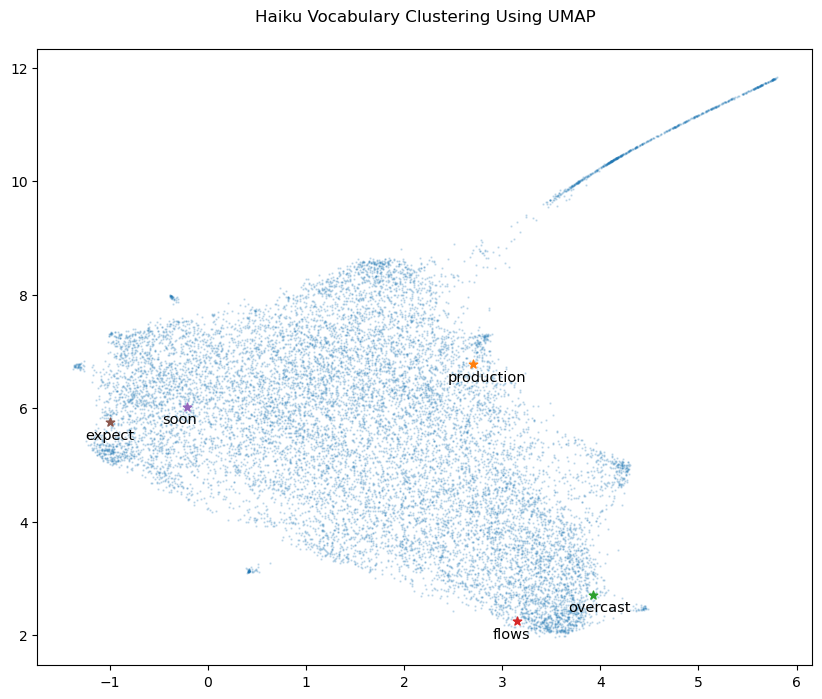

In [39]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=1001).fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=0.5, alpha=0.2, cmap='Spectral')

#Generate 5 random numbers from the word list
import random
randomlist = random.sample(range(0, len(words)), 5)

#Add star marks for the chosen random words with corresponding annotation
for i in randomlist:
    plt.scatter(cluster_embedding[i,0], cluster_embedding[i,1], marker='*', s=40)
    plt.annotate(words[i], (cluster_embedding[i,0]-.25, cluster_embedding[i,1]-.3), fontsize=10.5)

plt.title('Haiku Vocabulary Clustering Using UMAP', pad=20)
plt.show()

<h3>Clustering Haiku Using NMF and Visualizing Topics Using WordCloud

<h4>Create a TF-IDF matrix

In [40]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_haiku['clean_text'])

<h4>Create a NMF Model with 15 topics

In [41]:
from sklearn.decomposition import NMF

# Apply NMF with 15 components
num_topics = 15

# Create an instance of the NMF (Nonnegative Matrix Factorization) class from scikit-learn.
nmf = NMF(n_components=num_topics, init='random', random_state=101)

# Apply the NMF to the TF-IDF matrix
nmf_matrix = nmf.fit_transform(tfidf_matrix) 

<h4>Display the topics with top words

In [42]:
# Display the topics and the top words in each topic
feature_names = vectorizer.get_feature_names_out()

# This loop iterates over each topic extracted by NMF.
for topic_idx, topic in enumerate(nmf.components_):
    top_words_indices = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_indices]
    # The join method is used to concatenate the words into a single string, separated by commas.
    print(f"Topic #{topic_idx + 1}:  {', '.join(top_words)}")
    print('-' * 10)

Topic #1:  like, feel, look, looks, shit, does, feeling, feels, writing, lol
----------
Topic #2:  love, happy, fall, person, heart, hate, birthday, baby, friends, thank
----------
Topic #3:  people, hate, think, say, shit, need, things, stop, care, understand
----------
Topic #4:  gon, na, im, think, today, try, week, make, year, tonight
----------
Topic #5:  just, mean, does, say, need, wanted, trying, fuck, realized, let
----------
Topic #6:  want, does, make, makes, eat, talk, baby, things, sleep, home
----------
Topic #7:  time, long, remember, work, think, year, waste, night, having, come
----------
Topic #8:  really, need, shit, good, hate, think, wish, bad, man, work
----------
Topic #9:  did, think, today, say, wish, said, things, come, lol, night
----------
Topic #10:  got, ta, shit, ai, say, fuck, work, man, cause, way
----------
Topic #11:  day, good, today, happy, hope, morning, birthday, great, night, new
----------
Topic #12:  going, im, today, sleep, work, way, tomorrow

<h4>Visualize the top words in bar plot

In [43]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 5, figsize=(9.5,5.5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(nmf.components_):
        top_words_indices = topic.argsort()[-n_top_words:]
        top_words = feature_names[top_words_indices]
        weights = topic[top_words_indices]

        ax = axes[topic_idx]
        ax.barh(top_words, weights, height=0.8)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 10})
        ax.tick_params(axis="both", which="major", labelsize=8.5)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=15, y=1.01)
    plt.tight_layout()

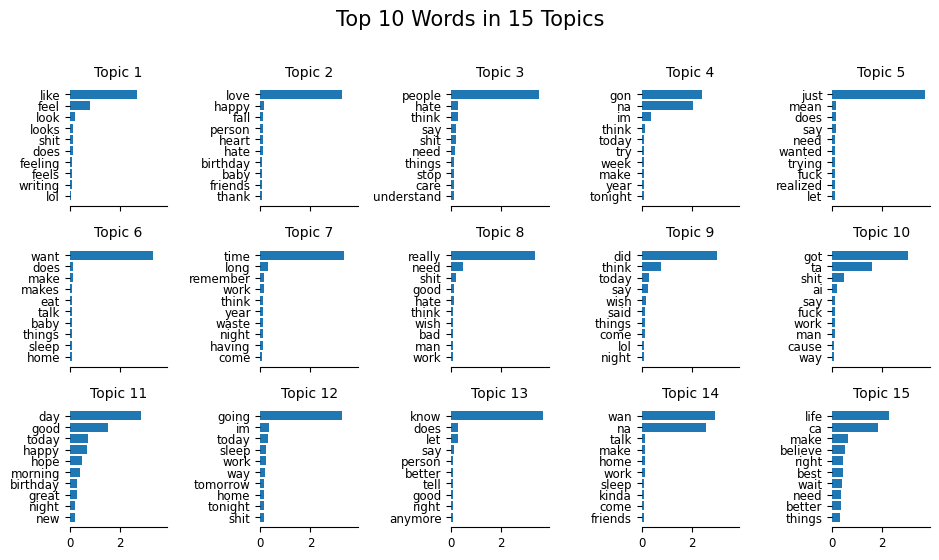

In [44]:
plot_top_words(nmf, feature_names, n_top_words=10, title='Top 10 Words in 15 Topics')

<h3>Use WordCloud to Show Some of the Topics

<h4>Add a new column to the dataframe that labels each haiku with one of the topics

In [45]:
topic_results = nmf.transform(tfidf_matrix)
df_haiku['Topic'] = topic_results.argmax(axis=1)+1

In [46]:
df_haiku.head()

,source,0,1,2,full,clean_text,Topic
0,tempslibres,fishing boats,colors of,the rainbow,fishing boats colors of the rainbow,fishing boats colors of the rainbow,11
1,tempslibres,ash wednesday--,trying to remember,my dream,ash wednesday-- trying to remember my dream,ash wednesday trying to remember my dream,15
2,tempslibres,snowy morn--,pouring another cup,of black coffee,snowy morn-- pouring another cup of black coffee,snowy morn pouring another cup of black coffee,11
3,tempslibres,shortest day,flames dance,in the oven,shortest day flames dance in the oven,shortest day flames dance in the oven,11
4,tempslibres,haze,half the horse hidden,behind the house,haze half the horse hidden behind the house,haze half the horse hidden behind the house,7


<h4>Show some of the topics using WordCloud

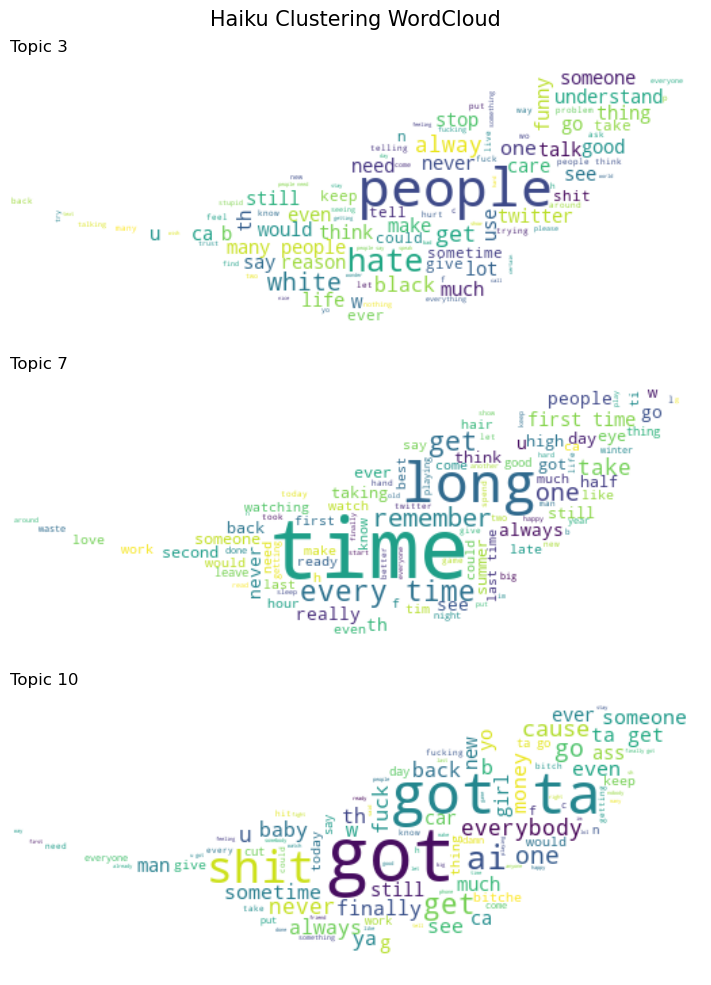

In [47]:
#Import libraries
import random
from wordcloud import WordCloud
from PIL import Image

#Create a random list to generate random 3 topics
randomlist = sorted(random.sample(range(0, num_topics), 3))

fig, axs = plt.subplots(3, figsize=(10,10))
mask = np.array(Image.open('1.png'))

k = 0
for i in range(len(axs)):
    wc = WordCloud(colormap='viridis_r', background_color='white', max_words=100,
                   stopwords=stopwords.words('english'), mask=mask)
    im = wc.generate(df_haiku[df_haiku['Topic']==randomlist[k]+1]['clean_text'].to_string())
    axs[i].imshow(im, interpolation='bilinear')
    axs[i].axis("off")
    axs[i].set_title('Topic ' + str(randomlist[k]+1), loc='left', fontsize=12)
    k += 1
    
plt.suptitle('Haiku Clustering WordCloud', size=15)
        
plt.tight_layout()
plt.show()

<h2>V: Is it possible to write Haiku like a poet?
       <i>  —Generate Haiku using LSTM</i>

<h3>Import Libraries

In [48]:
import tensorflow as tf
from keras import Input, Model
from keras.activations import softmax
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import preprocessing , utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<h3>Data Preprocessing

Due to the huge size of the dataset, it is difficult to train the model using my personal computer. Thus, I decided to check the data again to see if I can delete some haiku to make the data smaller.

<h4>Remove some source

In [49]:
df_haiku['source'].value_counts()

source
twaiku         111727
img2poems       13538
sballas          8130
gutenberg        5494
tempslibres      5233
Name: count, dtype: int64

Column 'twaiku' has the most haiku. Unfortunately, the data is too huge for my model. I will delete this source and keep other sources for training later.

In [50]:
df_train = df_haiku.drop(df_haiku[df_haiku['source']=='twaiku'].index)
df_train['source'].value_counts()

source
img2poems      13538
sballas         8130
gutenberg       5494
tempslibres     5233
Name: count, dtype: int64

The data size is smaller. Now I want to see the distribution of the haiku length to determine which length is ideal.

<h4>Calculate number of words in each haiku

In [51]:
df_train['length'] = df_train['clean_text'].apply(lambda x: len(x.split()))

In [52]:
df_train.head()

,source,0,1,2,full,clean_text,Topic,length
0,tempslibres,fishing boats,colors of,the rainbow,fishing boats colors of the rainbow,fishing boats colors of the rainbow,11,6
1,tempslibres,ash wednesday--,trying to remember,my dream,ash wednesday-- trying to remember my dream,ash wednesday trying to remember my dream,15,7
2,tempslibres,snowy morn--,pouring another cup,of black coffee,snowy morn-- pouring another cup of black coffee,snowy morn pouring another cup of black coffee,11,8
3,tempslibres,shortest day,flames dance,in the oven,shortest day flames dance in the oven,shortest day flames dance in the oven,11,7
4,tempslibres,haze,half the horse hidden,behind the house,haze half the horse hidden behind the house,haze half the horse hidden behind the house,7,8


<h4>Show distribution of haiku length

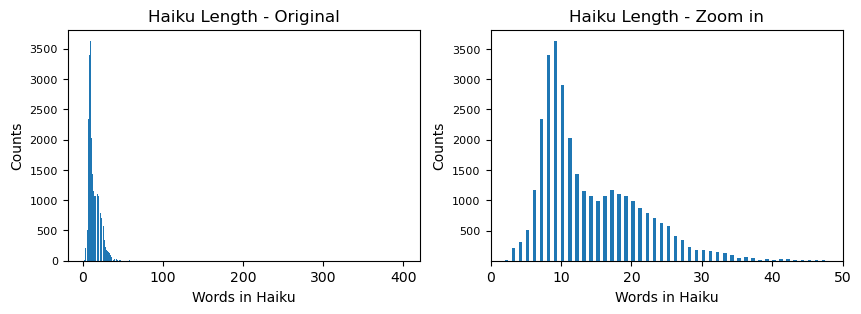

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))

axes[0].hist(df_train['length'], bins=500)
axes[0].set_title('Haiku Length - Original')
axes[0].set_xlabel('Words in Haiku')
axes[0].set_ylabel('Counts')

axes[1].hist(df_train['length'], bins=800, bottom=1)
axes[1].set_xlim([0, 50])
axes[1].set_xlabel('Words in Haiku')
axes[1].set_ylabel('Counts')
axes[1].set_title('Haiku Length - Zoom in')

axes[0].yaxis.set_tick_params(labelsize=8)
axes[1].yaxis.set_tick_params(labelsize=8)

plt.show()

Haiku rules show us that there should be 17 (5-7-5 in each line) syllables in one haiku. If we have 17 words instead, it should be enough for the rule. However, based on the histogram above, I want to remove the length over 20 to keep the most of the data.

<h4>Drop haiku that is too long for training

In [54]:
#Drop haiku that have more than 25 words
df_train = df_train.drop(df_train[df_train['length'] >= 20].index)

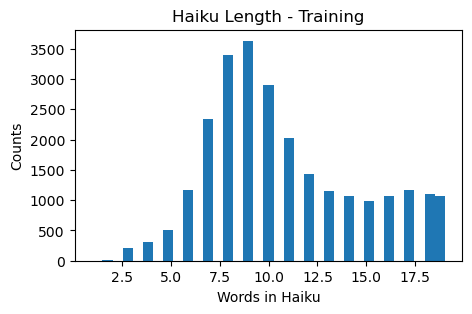

In [55]:
plt.figure(figsize=(5,3))

plt.hist(df_train['length'], bins=35)
plt.title('Haiku Length - Training')
plt.xlabel('Words in Haiku')
plt.ylabel('Counts')

plt.show()

Now the data is better for training purpose.

<h3>Create a LSTM Model

In [56]:
#Convert all haiku into a string
text = '\n'.join(df_train['clean_text'].tolist())

In [57]:
#Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

In [58]:
#Calculate the vocabulary size
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

25099


<h4>Create input sequences and corresponding labels

In [59]:
# Create input sequences and corresponding labels
input_sequences = []
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [60]:
input_sequences[:5]

[[999, 1641],
 [999, 1641, 618],
 [999, 1641, 618, 3],
 [999, 1641, 618, 3, 1],
 [999, 1641, 618, 3, 1, 735]]

<h4>Calculate max sequence length for padding

In [61]:
max_sequence_length = max([len(x) for x in input_sequences])
print(max_sequence_length)

19


<h4>Pad the sequences and separate the sequences into X and y

In [62]:
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
X, y = input_sequences[:,:-1],input_sequences[:,-1]

In [63]:
y = tf.keras.utils.to_categorical(y, num_classes=VOCAB_SIZE)

<h4>Build the LSTM model

In [64]:
# Build the LSTM model
#Initiate a Sequential model
model = Sequential()

#Add embedding layer with VOCAB_SIZE, 240 word embedding dimention, and the max length of the sequence(excluded the last word)
model.add(Embedding(VOCAB_SIZE, 240, input_length=max_sequence_length-1))

#Add LSTM layers
model.add(LSTM(150, return_sequences = True))
model.add(LSTM(100))

#Add Dense layer using relu
model.add(Dense(150, activation = 'relu'))

#Add the last layer with softmax and the number of units is the VOCAB_SIZE
model.add(Dense(VOCAB_SIZE, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 240)           6023760   
                                                                 
 lstm (LSTM)                 (None, 18, 150)           234600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               100400    
                                                                 
 dense (Dense)               (None, 150)               15150     
                                                                 
 dense_1 (Dense)             (None, 25099)             3789949   
                                                                 
Total params: 10,163,859
Trainable params: 10,163,859
Non-trainable params: 0
_________________________________________________________________


In [65]:
#Create a data generator to feed data with batches. It can avoid out-of-memory issue when training 
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [66]:
data = DataGenerator(X,y, batch_size=64)

In [67]:
model.fit(data, epochs=500, verbose=1)
model.save('lstm_model.keras')

Epoch 1/500
3946/3946 [==============================] - 53s 13ms/step - loss: 7.2900 - accuracy: 0.0827
Epoch 2/500
3946/3946 [==============================] - 50s 13ms/step - loss: 6.7316 - accuracy: 0.0999
Epoch 3/500
3946/3946 [==============================] - 51s 13ms/step - loss: 6.4274 - accuracy: 0.1106
Epoch 4/500
3946/3946 [==============================] - 50s 13ms/step - loss: 6.1857 - accuracy: 0.1188
Epoch 5/500
3946/3946 [==============================] - 50s 13ms/step - loss: 5.9741 - accuracy: 0.1262
Epoch 6/500
3946/3946 [==============================] - 50s 13ms/step - loss: 5.7833 - accuracy: 0.1342
Epoch 7/500
3946/3946 [==============================] - 50s 13ms/step - loss: 5.6017 - accuracy: 0.1409
Epoch 8/500
3946/3946 [==============================] - 50s 13ms/step - loss: 5.4289 - accuracy: 0.1487
Epoch 9/500
3946/3946 [==============================] - 50s 13ms/step - loss: 5.2666 - accuracy: 0.1557
Epoch 10/500
3946/3946 [==============================]

3946/3946 [==============================] - 50s 13ms/step - loss: 1.6309 - accuracy: 0.6288
Epoch 79/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.6241 - accuracy: 0.6298
Epoch 80/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.6140 - accuracy: 0.6317
Epoch 81/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.6044 - accuracy: 0.6336
Epoch 82/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.5982 - accuracy: 0.6357
Epoch 83/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.5847 - accuracy: 0.6382
Epoch 84/500
3946/3946 [==============================] - 51s 13ms/step - loss: 1.5837 - accuracy: 0.6387
Epoch 85/500
3946/3946 [==============================] - 51s 13ms/step - loss: 1.5621 - accuracy: 0.6418
Epoch 86/500
3946/3946 [==============================] - 51s 13ms/step - loss: 1.5626 - accuracy: 0.6411
Epoch 87/500
3946/3946 [==============================] - 5

3946/3946 [==============================] - 50s 13ms/step - loss: 1.2532 - accuracy: 0.7038
Epoch 155/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.2518 - accuracy: 0.7042
Epoch 156/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.2537 - accuracy: 0.7049
Epoch 157/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.2549 - accuracy: 0.7036
Epoch 158/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.2492 - accuracy: 0.7042
Epoch 159/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.2421 - accuracy: 0.7064
Epoch 160/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.2467 - accuracy: 0.7055
Epoch 161/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.2365 - accuracy: 0.7068
Epoch 162/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.2386 - accuracy: 0.7065
Epoch 163/500
3946/3946 [==========================

3946/3946 [==============================] - 50s 13ms/step - loss: 1.1433 - accuracy: 0.7273
Epoch 231/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.1427 - accuracy: 0.7269
Epoch 232/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.1341 - accuracy: 0.7287
Epoch 233/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.1370 - accuracy: 0.7270
Epoch 234/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.1404 - accuracy: 0.7274
Epoch 235/500
3946/3946 [==============================] - 51s 13ms/step - loss: 1.1348 - accuracy: 0.7279
Epoch 236/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.1325 - accuracy: 0.7291
Epoch 237/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.1347 - accuracy: 0.7286
Epoch 238/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.1391 - accuracy: 0.7282
Epoch 239/500
3946/3946 [==========================

3946/3946 [==============================] - 50s 13ms/step - loss: 1.0959 - accuracy: 0.7370
Epoch 307/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0984 - accuracy: 0.7351
Epoch 308/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.1005 - accuracy: 0.7356
Epoch 309/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0968 - accuracy: 0.7365
Epoch 310/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0898 - accuracy: 0.7381
Epoch 311/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0956 - accuracy: 0.7368
Epoch 312/500
3946/3946 [==============================] - 49s 13ms/step - loss: 1.1015 - accuracy: 0.7361
Epoch 313/500
3946/3946 [==============================] - 49s 13ms/step - loss: 1.0921 - accuracy: 0.7369
Epoch 314/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0940 - accuracy: 0.7378
Epoch 315/500
3946/3946 [==========================

3946/3946 [==============================] - 50s 13ms/step - loss: 1.0767 - accuracy: 0.7407
Epoch 383/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0828 - accuracy: 0.7398
Epoch 384/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0786 - accuracy: 0.7412
Epoch 385/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0738 - accuracy: 0.7408
Epoch 386/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0754 - accuracy: 0.7408
Epoch 387/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0866 - accuracy: 0.7392
Epoch 388/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0746 - accuracy: 0.7410
Epoch 389/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0748 - accuracy: 0.7423
Epoch 390/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0782 - accuracy: 0.7408
Epoch 391/500
3946/3946 [==========================

3946/3946 [==============================] - 50s 13ms/step - loss: 1.0754 - accuracy: 0.7411
Epoch 459/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0822 - accuracy: 0.7393
Epoch 460/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0781 - accuracy: 0.7407
Epoch 461/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0830 - accuracy: 0.7397
Epoch 462/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0736 - accuracy: 0.7415
Epoch 463/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0822 - accuracy: 0.7399
Epoch 464/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0787 - accuracy: 0.7401
Epoch 465/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0772 - accuracy: 0.7407
Epoch 466/500
3946/3946 [==============================] - 50s 13ms/step - loss: 1.0767 - accuracy: 0.7405
Epoch 467/500
3946/3946 [==========================

<h4>Create a function to generate haiku using the LSTM model

Since the model generates text word by word instead of line by line, I need a format to make the generated text looks like a haiku. It is impossible to get 5-7-5 syllable pattern because I didn't train the model on character level, so the best option for me is to create a 5-7-5 word pattern instead.

In [68]:
def generate_haiku(seed_text):
    #Put seed_text into 3 lines with 5-7-5 word rule.
    text = seed_text.split()
    line_1, line_2, line_3 = ([] for i in range(3))
    if len(text)> 12:
        line_3 = text[13:]
        line_2 = text[6:13]
        line_1 = text[:5]
    elif len(text)>5:
        line_2 = text[6:]
        line_1 = text[:5]
    else:
        line_1 = text

    #Generate the rest of the haiku words from the seed_text
    #Keep the first line with 5 words, the second line with 7 words, and the third line with 5 words 
    for i in range(1,4):
        if i==1:
            for _ in range(5-len(line_1)):
                token_list = tokenizer.texts_to_sequences([seed_text])[0] # tokenizing the seed text
                token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre') # padding
            #The model is used to predict the index of the next word in the sequence using the predict method. 
                predicted = np.argmax(model.predict(token_list, verbose=0)) 

                predicted_word = ""
                for word, index in tokenizer.word_index.items():
                    if index == predicted:
                        predicted_word = word
                        break
                seed_text = seed_text + ' ' + predicted_word
                line_1.append(predicted_word)
            line_1_text = ' '.join(line_1)
        if i==2:
            for _ in range(7-len(line_2)):
                token_list = tokenizer.texts_to_sequences([seed_text])[0] # tokenizing the seed text
                token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre') # padding
            #The model is used to predict the index of the next word in the sequence using the predict method. 
                predicted = np.argmax(model.predict(token_list, verbose=0)) 

                predicted_word = ""
                for word, index in tokenizer.word_index.items():
                    if index == predicted:
                        predicted_word = word
                        break
                seed_text = seed_text + ' ' + predicted_word
                line_2.append(predicted_word)
            line_2_text = ' '.join(line_2)

        if i==3:
            for _ in range(5-len(line_3)):
                token_list = tokenizer.texts_to_sequences([seed_text])[0] # tokenizing the seed text
                token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre') # padding
            #The model is used to predict the index of the next word in the sequence using the predict method. 
                predicted = np.argmax(model.predict(token_list, verbose=0)) 

                predicted_word = ""
                for word, index in tokenizer.word_index.items():
                    if index == predicted:
                        predicted_word = word
                        break
                seed_text = seed_text + ' ' + predicted_word
                line_3.append(predicted_word)
            line_3_text = ' '.join(line_3)
    haiku = (line_1_text +'\n'+ line_2_text +'\n'+ line_3_text)
    print(haiku)

<h4>Create a ineraction interface for users

In [69]:
def interaction():
    print("Please enter some beginning words (recommanded less than 5 words)for your haiku. \nEnter 'Bye' if you want to quit:\n")
    text = ''
    while True:
        text = input()
        if text =='Bye':
            print('Goodbye')
            break
        else:
            print('-'*50)
            haiku = generate_haiku(text)
            print('-'*50)        

<h4>Test the haiku generator

In [76]:
interaction()

Please enter some beginning words (recommanded less than 5 words)for your haiku. 
Enter 'Bye' if you want to quit:

Christmas
--------------------------------------------------
Christmas eve candles flicker through
our wine glasses cover the tips of
dry solace tempest milk on
--------------------------------------------------
Summer
--------------------------------------------------
Summer end the beach umbrella
man flat winter leaves doth finds his
tank tower all our horses
--------------------------------------------------
autumn leaves
--------------------------------------------------
autumn leaves the creak in
my left knee someone must afford shadows
make chaos fight away with
--------------------------------------------------
Bye
Goodbye


<h2>VI: Conclusion

For this project, I shared the world of haiku by showing the Wikipedia page with text smmarization, the translation of original Japanese haiku, EDA of haiku dataset and clustering, and finally I create a LSTM model to generate some haiku.


- It is difficult to use the full data (with 144,122 rows and more than 400 sequence length) to pad sequences and do the one-hot encoding with vocabulary size of more than 40,000. I have to shrink the size of the dataset in order to train the model properly using my personal computer.
- The limitation of my LSTM model is that it can only generate fixed length of words. To get a better form of haiku, I set each line of words with 5, 7, 5 individually. However, because the nature of poetry is to separate lines based on the meaning of the context, it is hard to make the generated haiku separated naturally. Although the generated haiku does't make sense, I can still feel some 'poetic vibes' among the words.
- If I want to get the 5-7-5 syllables instead of 5-7-5 words, I may need to tokenize the text on character level. However, there might be some unknown words created randomly.
- I actually did another seq2seq model but does not perform as good as LSTM. I didn't include the seq2seq model in the project due to time constraints, but I will try to reconstruct the model once I have time to see if it generates better haikus. After all, it can generate different lengths of words for each line, which is better than the fixed number of words.
